# Google Drive mounting



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and constants

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append('..')
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from src.detector import crop_coin
import pandas as pd
from src.utils import get_filename, MARCINIAK_DATASET_PATH, NIEMCZYK_DATASET_PATH, side_path, raw_coins_path, cropped_coins_path
from src.detector import crop_all_coins
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [14]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Image                    module      <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
MARCINIAK_DATASET_PATH   str         ../data/marciniak/sztandar_1930
NIEMCZYK_DATASET_PATH    str         ../data/niemczyk/sztandar_1930
clear_output             function    <function clear_output at 0x10de148b0>
crop_all_coins           function    <function crop_all_coins at 0x12f661700>
crop_coin                function    <function crop_coin at 0x12f661c10>
cropped_coins_path       function    <function <lambda> at 0x12ed3e1f0>
cv2                      module      <module 'cv2.cv2' from '/<...>v2.cpython-38-darwin.so'>
ds_path                  str         ../data/marciniak/sztandar_1930
ellipse_perimeter        function    <function ellipse_perimeter at 0x12b41a8b0>
get_filename             function    <function get_filename at 0x12ed38e50>
hough_ellipse            function    <function hough_ellip

# Circles

In [18]:
!python3 ../src/../src/3_detector_pipeline.py

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


## Investigating of results

In [20]:
ds_path = MARCINIAK_DATASET_PATH
root = cropped_coins_path(ds_path)

### False circle

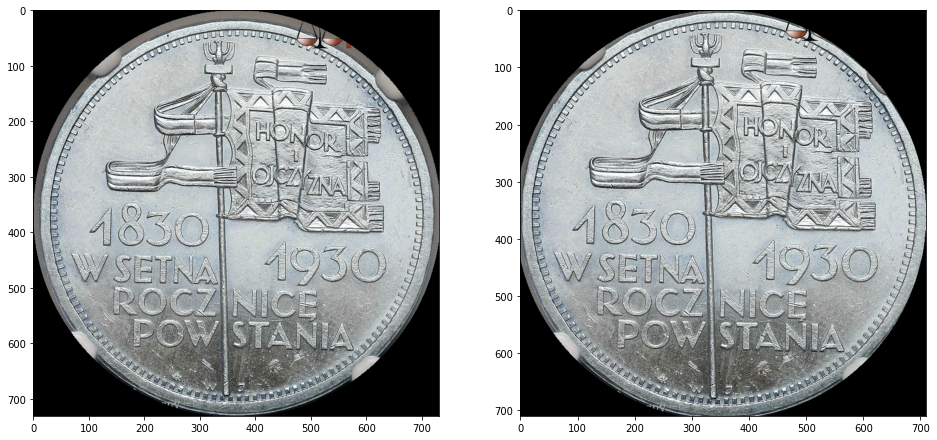

In [19]:
name = './124_1.jpg'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

img_orig = cv2.imread(root + "/" + name)
im_1 = crop_coin(img_orig)
im_2 = im_1[10:, 10:]
im_2 = crop_coin(im_2)

ax1.imshow(im_1)
ax2.imshow(im_2)
plt.show()

### Individual mask

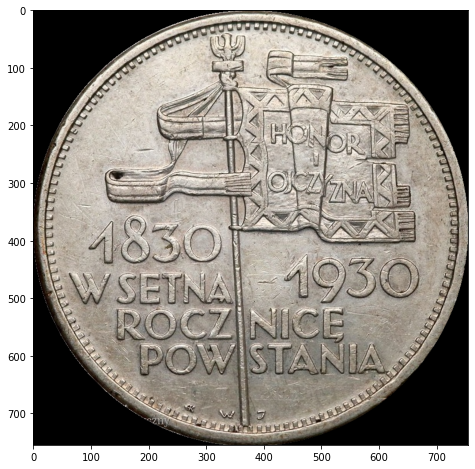

In [22]:
name = './101_1.jpg'

fig, ax = plt.subplots(figsize=(8, 8))

im = cv2.imread(root + "/" + name)
im = crop_coin(im)

ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

## Fixing [DEPRECATED]

In [ ]:
def validate_masks(path, csv_out):
    path = path + '/'
    img_list = sorted(os.listdir(path))
    
    try:
        df = pd.read_csv(csv_out)
    except:
        df = pd.DataFrame({"name": img_list, "valid": None, "offset": None})

    for i, row in df.iterrows():
        if pd.isna(row["valid"]):
            im = Image.open(path + row["name"])
            plt.figure(figsize=(8,8))
            plt.imshow(im)
            plt.axis('off') 
            plt.title(row["name"])
            plt.show()
            inp = input()
            if inp == "":
                valid = True
            else:
                valid = False

            df["valid"][i] = valid
            df.to_csv(csv_out, index=None)
            clear_output(wait=True)
      
    return (df)

In [ ]:
# df = validate_masks(root + "/cropped", root + "/cropped/" + "valid.csv")
df[df["valid"] != 0] 

NameError: name 'df' is not defined

In [ ]:
def fix_masks(path, csv_out):
    path = path + '/'
    img_list = sorted(os.listdir(path))
    
    try:
        df = pd.read_csv(csv_out)
    except:
        df = pd.DataFrame({"name": img_list, "valid": None, "offset": None})
    df['offset'] = df['offset'].astype(dtype=object)

    for i, row in df.iterrows():
        offset = [0]*4
        while True:
            if row["valid"] != False:
                break
            im = cv2.imread(path + row["name"])
            if offset != [0]*4:
                h, w = im.shape[0:2]
                im = im[offset[0]:h-offset[2]-1, offset[3]:w-offset[1]-1]
                im = crop_coin(im)
            plt.figure(figsize=(12,12))
            plt.imshow(im)
            plt.axis('off') 
            plt.title(row["name"])
            plt.show()
            inp = input()
            if inp == "":
                df["valid"][i] = True
                df["offset"][i] = offset
                cv2.imwrite(path + row["name"], im)
                break
            elif inp == "-1":
                df["valid"][i] = False
                break
            else:
                offset = list(map(lambda x: int(x), inp.split(" ")))
                if len(offset)==1:
                    offset = offset * 4
                elif len(offset)==2:
                    offset = offset * 2
                elif len(offset)!=4:
                    print("bad offset")
                    offset = [0]*4
                clear_output(wait=True)

        df.to_csv(csv_out, index=None)
        clear_output(wait=True)

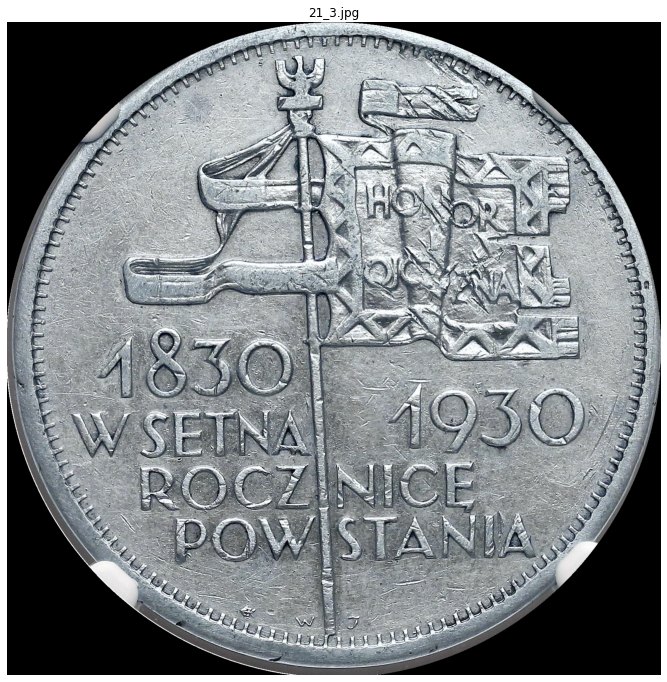

KeyboardInterrupt: Interrupted by user

In [ ]:
fix_masks(root + "/cropped", root + "/cropped/" + "valid.csv")

# Ellipses

In [ ]:
name = './339_2.jpg'
height_img_ds = 500

img_orig = cv2.imread(name)

ds_ratio = height_img_ds/img_orig.shape[0] 
img_ds = cv2.resize(img_orig, None, fx=ds_ratio, fy=ds_ratio, interpolation=cv2.INTER_AREA) # downsampling

gray = cv2.cvtColor(img_ds, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

thresh = cv2.Canny(gray, 50, 100)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

_, th = cv2.threshold(closed, 1, 1, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(th, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
img_max_contour = cv2.drawContours(np.zeros(gray.shape), max_contour, -1, (255,255,255), 1)

elipses = hough_ellipse(img_max_contour, accuracy=30, threshold=100, min_size=int(0.4 * closed.shape[0]))
elipses.sort(order='accumulator')
best_ellipse = list(elipses[-1])
(yc, xc, a, b), orientation = [int(round(x/ds_ratio)) for x in best_ellipse[1:5]], best_ellipse[5]
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
img_orig[cy, cx] = (250, 0, 0)

fig, ax = plt.subplots( figsize=(8, 8))
ax.imshow(img_orig)
plt.show()